# Import một số thư viện quan trọng

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
%mkdir /content/model

mkdir: cannot create directory ‘/content/model’: File exists


In [ ]:
#Python Vietnamese Toolkit
!pip install pyvi

# Load data

In [ ]:
DATA = '/content/train.csv'
DEV_DATA = '/content/dev.csv'
TEST_DATA = '/content/test.csv'

# read data
train_data = pd.read_csv(DATA)
dev_data = pd.read_csv(DEV_DATA)
test_data = pd.read_csv(TEST_DATA)

print(len(train_data))
print(len(dev_data))
print(len(test_data))

X_train = train_data['free_text']
y_train = train_data['label_id'].values

X_dev = dev_data['free_text']
y_dev = dev_data['label_id'].values

X_test = test_data['free_text']
y_test = test_data['label_id'].values

24048
2672
6680


In [ ]:
print('Phần tử đầu tiên trong X_train:')
print('\t', X_train[0])
print('Phần tử đầu tiên trong X_dev:')
print('\t', X_dev[0])
print('Phần tử đầu tiên trong X_test:')
print('\t', X_test[0])

Phần tử đầu tiên trong X_train:
	 Em được làm fan cứng luôn rồi nè ❤️ reaction quá hay quá cute coi mấy giờ này quá hợp lí =]]]
Phần tử đầu tiên trong X_dev:
	 Coi cười xỉu
Phần tử đầu tiên trong X_test:
	 Đừng cố biện minh =)))) choi lon


# Tiền xử lí dữ liệu

## Xử lí stopword trong tiếng Việt

Stop Words là một số từ ngữ, bị các công cụ tìm kiếm bỏ qua một phần hoặc hoàn toàn. Những từ như : “a, an, of, or, many vv …” chiếm khoảng 25% các bài viết blog trên web. Các từ này không hề có liên quan gì đến nội dung và ý nghĩa của bài viết. Các công cụ tìm kiếm, trong cả những truy vấn tìm kiếm lẫn trong kết quả đề xuất, thường bỏ qua những Stop Words này.

In [ ]:
STOPWORDS = '/content/vietnamese-stopwords-dash.txt'
with open(STOPWORDS, "r") as ins:
    stopwords = []
    for line in ins:
        dd = line.strip('\n')
        stopwords.append(dd)
    stopwords = set(stopwords)
print('Năm stopword đầu tiên: ')
list(stopwords)[:5]

Năm stopword đầu tiên: 


['từng_thời_gian', 'bỗng_không', 'có_cơ', 'quả_thật', 'thời_gian_tính']

In [ ]:
#Lọc các stopword
def filter_stop_words(train_sentences, stop_words):
  new_sent = [word for word in train_sentences.split() if word not in stop_words]
  train_sentences = ' '.join(new_sent)
  return train_sentences

In [ ]:
x = filter_stop_words(X_train[0], stopwords)
print(X_train[0])
print(x)

Em được làm fan cứng luôn rồi nè ❤️ reaction quá hay quá cute coi mấy giờ này quá hợp lí =]]]
Em fan cứng nè ❤️ reaction cute coi mấy hợp lí =]]]


## Xử lí emoji - biểu tượng cảm xúc trong tiếng Việt

In [ ]:
import re
def deEmojify(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)

## Tổng hợp 2 phương thức trên

In [ ]:
from pyvi.ViTokenizer import ViTokenizer

Tokenization là quá trình tách một cụm từ, câu, đoạn văn, một hoặc nhiều tài liệu văn bản thành các đơn vị nhỏ hơn. Mỗi đơn vị nhỏ hơn này được gọi là Tokens. Có thể coi tokens là các khối xây dựng của NLP và tất cả các mô hình NLP đều xử lý văn bản thô ở cấp độ các Tokens.

In [ ]:
def preprocess(text, tokenized = True, lowercased = True):
    text = ViTokenizer.tokenize(text) if tokenized else text
    text = filter_stop_words(text, stopwords)
    text = deEmojify(text)
    text = text.lower() if lowercased else text
    return text

In [ ]:
x = preprocess(X_train[0])
print(X_train[0])
print(x)

Em được làm fan cứng luôn rồi nè ❤️ reaction quá hay quá cute coi mấy giờ này quá hợp lí =]]]
em fan cứng nè ❤ ️ reaction cute coi mấy hợp_lí = ] ] ]


## Rút trích đặc trưng

In [ ]:
def pre_process_features(X, y, tokenized = True, lowercased = True):
    X = [preprocess(str(p), tokenized = tokenized, lowercased = lowercased) for p in list(X)]
    for idx, ele in enumerate(X):
        if not ele:
            np.delete(X, idx)
            np.delete(y, idx)
    return X, y

In [ ]:
x, y = pre_process_features(X_train[:5], y_train[:5])
print(X_train[0], y_train[0])
print(x[0], y[0])

Em được làm fan cứng luôn rồi nè ❤️ reaction quá hay quá cute coi mấy giờ này quá hợp lí =]]] 0
em fan cứng nè ❤ ️ reaction cute coi mấy hợp_lí = ] ] ] 0


# Huấn luyện và kiểm thử mô hình

In [ ]:
import pandas as pd
import numpy as np
import re
import pickle

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Input, Dense, Embedding, Conv2D, MaxPool2D
from tensorflow.keras.layers import Reshape, Flatten, Dropout, Concatenate
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import text, sequence

from sklearn.metrics import f1_score, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit


In [ ]:
train_X, train_y = pre_process_features(X_train, y_train, tokenized=True, lowercased = True)
dev_X, dev_y = pre_process_features(X_dev, y_dev, tokenized=True, lowercased = True)
test_X, test_y = pre_process_features(X_test, y_test, tokenized=True, lowercased = True)

In [ ]:
def make_features(X, y, tokenizer, is_one_hot_label=True):
    X = tokenizer.texts_to_sequences(X)
    X = sequence.pad_sequences(X, maxlen=sequence_length)
    if is_one_hot_label:
        y = to_categorical(y, num_classes=3)

    return X, y

In [ ]:
%cd /content
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.vi.300.vec.gz

/content
--2024-12-27 07:15:51--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.vi.300.vec.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 108.157.254.15, 108.157.254.102, 108.157.254.124, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|108.157.254.15|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1235219084 (1.1G) [binary/octet-stream]
Saving to: ‘cc.vi.300.vec.gz’

cc.vi.300.vec.gz    100%[===================>]   1.15G  23.5MB/s    in 52s     

2024-12-27 07:16:44 (22.5 MB/s) - ‘cc.vi.300.vec.gz’ saved [1235219084/1235219084]



In [ ]:
!gzip -d cc.vi.300.vec.gz

In [ ]:
EMBEDDING_FILE = '/content/cc.vi.300.vec'

embeddings_index = {}
with open(EMBEDDING_FILE, encoding='utf8') as f:
    for line in f:
        values = line.rstrip().rsplit(' ')
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

In [ ]:
import pickle

with open('embeddings_index.pkl', 'wb') as file:
    pickle.dump(embeddings_index, file)

In [ ]:
with open('embeddings_index.pkl', 'rb') as file:
    embeddings_index = pickle.load(file)

In [ ]:
vocabulary_size = 10000
sequence_length = 100
embedding_dim = 300

tokenizer = text.Tokenizer(lower=False, filters='!"#$%&()*+,-./:;<=>?@[\\]^`{|}~\t\n')
tokenizer.fit_on_texts(train_X)
with open('/content/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

word_index = tokenizer.word_index
# num_words = min(vocabulary_size, len(word_index) + 1)
num_words = len(word_index) + 1
embedding_matrix = np.zeros((num_words, embedding_dim))

for word, i in word_index.items():
    if i >= vocabulary_size:
        continue

    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Make features
train_X, train_y = make_features(train_X, train_y, tokenizer)
dev_X, dev_y = make_features(dev_X, dev_y, tokenizer)
test_X, test_y = make_features(test_X, test_y, tokenizer, is_one_hot_label=False)

## Text CNN

In [ ]:
MODEL_FILE = '/content/model/Text_CNN_model_v13.keras'

vocabulary_size = 10000
sequence_length = 100

embedding_dim = 300
batch_size = 256
epochs = 40
drop = 0.5

filter_sizes = [2,3,5]
num_filters = 32


inputs = Input(shape=(sequence_length,), dtype='int32')
embedding = Embedding(input_dim=num_words, output_dim=embedding_dim, input_length=sequence_length, weights=[embedding_matrix])(inputs)
reshape = Reshape((sequence_length,embedding_dim,1))(embedding)

conv_0 = Conv2D(num_filters, kernel_size=(filter_sizes[0], embedding_dim), padding='valid', kernel_initializer='normal', activation='elu')(reshape)
conv_1 = Conv2D(num_filters, kernel_size=(filter_sizes[1], embedding_dim), padding='valid', kernel_initializer='normal', activation='elu')(reshape)
conv_2 = Conv2D(num_filters, kernel_size=(filter_sizes[2], embedding_dim), padding='valid', kernel_initializer='normal', activation='elu')(reshape)

maxpool_0 = MaxPool2D(pool_size=(sequence_length - filter_sizes[0] + 1, 1), strides=(1,1), padding='valid')(conv_0)
maxpool_1 = MaxPool2D(pool_size=(sequence_length - filter_sizes[1] + 1, 1), strides=(1,1), padding='valid')(conv_1)
maxpool_2 = MaxPool2D(pool_size=(sequence_length - filter_sizes[2] + 1, 1), strides=(1,1), padding='valid')(conv_2)

concatenated_tensor = Concatenate(axis=1)([maxpool_0, maxpool_1, maxpool_2])
flatten = Flatten()(concatenated_tensor)
dropout = Dropout(drop)(flatten)
output = Dense(units=3, activation='softmax')(dropout)

# this creates a model that includes
model = Model(inputs=inputs, outputs=output)

model.summary()

checkpoint = ModelCheckpoint('weights.{epoch:03d}-{val_acc:.4f}.keras', monitor='val_acc', verbose=1, save_best_only=True, mode='auto')
adam = Adam(learning_rate=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, weight_decay=0.0)

model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(train_X, train_y, batch_size=batch_size, epochs=epochs, verbose=1,
          validation_data=(dev_X, dev_y))
model.save(MODEL_FILE)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 100)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 100, 300)       │      5,897,100 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 100, 300, 1)    │              0 │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 99, 1, 32)      │         19,232 │ reshape[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 98, 1, 32)      │         28,832 │ reshape[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 96, 1, 32)      │         48,032 │ reshape[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 1, 1, 32)       │              0 │ conv2d[0][0]           │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 1, 1, 32)       │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 1, 1, 32)       │              0 │ conv2d_2[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 3, 1, 32)       │              0 │ max_pooling2d[0][0],   │
│                           │                        │                │ max_pooling2d_1[0][0], │
│                           │                        │                │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 96)             │              0 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 96)             │              0 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 3)              │            291 │ dropout[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 5,993,487 (22.86 MB)

 Trainable params: 5,993,487 (22.86 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
94/94 ━━━━━━━━━━━━━━━━━━━━ 30s 156ms/step - accuracy: 0.6761 - loss: 0.8788 - val_accuracy: 0.8196 - val_loss: 0.5750
Epoch 2/40
94/94 ━━━━━━━━━━━━━━━━━━━━ 15s 20ms/step - accuracy: 0.8264 - loss: 0.5608 - val_accuracy: 0.8200 - val_loss: 0.5382
Epoch 3/40
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.8314 - loss: 0.5173 - val_accuracy: 0.8230 - val_loss: 0.5117
Epoch 4/40
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.8394 - loss: 0.4816 - val_accuracy: 0.8293 - val_loss: 0.4872
Epoch 5/40
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.8399 - loss: 0.4630 - val_accuracy: 0.8387 - val_loss: 0.4643
Epoch 6/40
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.8534 - loss: 0.4264 - val_accuracy: 0.8458 - val_loss: 0.4458
Epoch 7/40
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.8572 - loss: 0.4026 - val_accuracy: 0.8473 - val_loss: 0.4300
Epoch 8/40
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.8651 - loss: 0.3757 - val_accuracy: 0.8503 

[[5314   80  154]
 [ 238  128   78]
 [ 312   47  329]]
F1 - micro: 0.8639221556886227
F1 - macro: 0.6081197749473678
Accuracy: 0.8639221556886227


<Axes: >

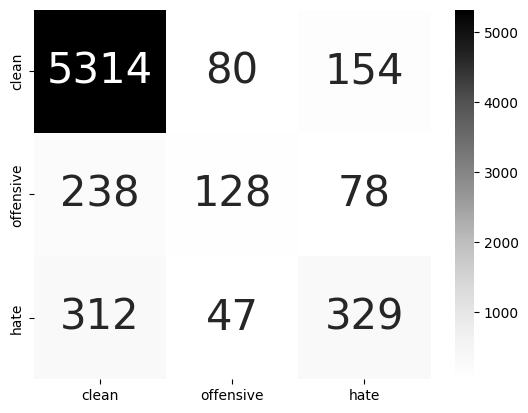

In [ ]:
from keras import models
model = models.load_model('/content/model/Text_CNN_model_v13.keras')
prediction = model.predict(test_X, batch_size=batch_size, verbose=0)
y_pred = prediction.argmax(axis=-1)

cf1 = confusion_matrix(test_y, y_pred)
print(cf1)

evaluation = f1_score(test_y, y_pred, average='micro')

print("F1 - micro: " + str(evaluation))

evaluation = f1_score(test_y, y_pred, average='macro')
print("F1 - macro: " + str(evaluation))

evaluation = accuracy_score(test_y, y_pred)
print("Accuracy: " + str(evaluation))

df_cm1 = pd.DataFrame(cf1, index = ["clean","offensive","hate"],
                  columns = ["clean","offensive","hate"])
plt.clf()
sn.heatmap(df_cm1, annot=True, cmap="Greys",fmt='g', cbar=True, annot_kws={"size": 30})